# Prosocial Chimps Lab, Part1

##### Keywords: glm, varying intercept, multiple varying intercept, posterior predictive

##### Data: data/chimpanzees2.csv

>The data for this example come from an experiment aimed at evaluating the prosocial tendencies of chimpanzees (Pan troglodytes). The experimental structure mimics many common experiments conducted on human students (Homo sapiens studiensis) by economists and psychologists. A focal chimpanzee sits at one end of a long table with two levers, one on the left and one on the right in FIGURE 10.1. On the table are four dishes which may contain desirable food items. The two dishes on the right side of the table are attached by a mechanism to the right-hand lever. The two dishes on the left side are similarly attached to the left-hand lever.

>When either the left or right lever is pulled by the focal animal, the two dishes on the same side slide towards opposite ends of the table. This delivers whatever is in those dishes to the opposite ends. In all experimental trials, both dishes on the focal animal's side contain food items. But only one of the dishes on the other side of the table contains a food item. Therefore while both levers deliver food to the focal animal, only one of the levers delivers food to the other side of the table.

>There are two experimental conditions. In the partner condition, another chimpanzee is seated at the opposite end of the table, as pictured in FIGURE 10.1. In the control condition, the other side of the table is empty. Finally, two counterbalancing treatments alternate which side, left or right, has a food item for the other side of the table. This helps detect any handedness preferences for individual focal animals. 

>When human students participate in an experiment like this, they nearly always choose the lever linked to two pieces of food, the prosocial option, but only when another student sits on the opposite side of the table. The motivating question is whether a focal chimpanzee behaves similarly, choosing the prosocial option more often when another animal is present. In terms of linear models, we want to estimate the interaction between condition (presence or absence of another animal) and option (which side is prosocial). (McElreath 292-293)



![](images/pchimps.png)

>Chimpanzee prosociality experiment, as seen from the perspective of the focal animal. The left and right levers are indicated in the foreground. Pulling either expands an accordion device in the center, pushing the food trays towards both ends of the table. Both food trays close to the focal animal have food in them. Only one of the food trays on the other side contains food. The partner condition means another animal, as pictured, sits on the other end of the table. Otherwise, the other end was empty. (McElreath 293)



## Seeing the Data

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pymc3 as pm

//anaconda/envs/py3l/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df=pd.read_csv("data/chimpanzees2.csv", sep=";")
df.head(100)

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,1,0,0,1,2,0,1,0
1,1,0,0,1,4,0,0,1
2,1,0,0,1,6,1,0,0
3,1,0,0,1,8,0,1,0
4,1,0,0,1,10,1,1,1
5,1,0,0,1,12,1,1,1
6,1,0,0,2,14,1,0,0
7,1,0,0,2,16,1,0,0
8,1,0,0,2,18,0,1,0
9,1,0,0,2,20,0,1,0


>We're going to focus on `pulled_left` as the outcome to predict, with `prosoc_left` and `condition` as predictor variables. The outcome `pulled_left` is a 0 or 1 indicator that the focal animal pulled the left-hand lever. The predictor `prosoc_left` is a 0/1 indicator that the left-hand lever was (1) or was not (0) attached to the prosocial option, the side with two pieces of food. The `condition` predictor is another 0/1 indicator, with value 1 for the partner condition and value 0 for the control condition. (McElreath 293)

In [3]:
df.shape

(504, 8)

Lets explore the data a bit...

In [4]:
gd={}
for k, v in df.groupby('actor'):
    temp = v.groupby(['condition', 'prosoc_left'])['pulled_left'].mean()
    gd[k] = temp.values
    #print(k, ldf.values)

For each actor we get the 4 combinations of condition/prosoc_left and see what fraction of times times that chimp pulled the left lever.

In [5]:
gd

{1: array([0.33333333, 0.5       , 0.27777778, 0.55555556]),
 2: array([1, 1, 1, 1]),
 3: array([0.27777778, 0.61111111, 0.16666667, 0.33333333]),
 4: array([0.33333333, 0.5       , 0.11111111, 0.44444444]),
 5: array([0.33333333, 0.55555556, 0.27777778, 0.5       ]),
 6: array([0.77777778, 0.61111111, 0.55555556, 0.61111111]),
 7: array([0.77777778, 0.83333333, 0.94444444, 1.        ])}

## 3 different Logistic regression models

Let $P$ be the indicator for `prosoc_left`, ie is the two-food or prosocial side is the left side(1) or the right side(0). Let $C$ be the indicator for `condition`, with 1 indicating the partner condition, ie a chimp at the other end, and a 0 indicating no animal. Let $L$ (`pulled_left`) indicate with a 1 value that the left side lever is pulled and with a 0 that the right one is pulled.

### Full Model

![](images/modelfull.png)

In [6]:
def full_model():
    with pm.Model() as ps1:
        betapc = pm.Normal("betapc", 0, 10)
        betap = pm.Normal("betap", 0, 10)
        alpha = pm.Normal('alpha', 0, 10)
        logitpi = alpha + (betap + betapc*df.condition)*df.prosoc_left
        o = pm.Bernoulli("pulled_left", p=pm.math.invlogit(logitpi), observed=df.pulled_left)
        
    return ps1

>note that there is no main effect of $C_i$ itself, no plain beta-coefficient for condition. Why? Because there is no reason to hypothesize that the presence or absence of another animal creates a tendency to pull the left-hand lever. This is equivalent to assuming that the main effect of condition is exactly zero. You can check this assumption later, if you like.

>The priors above are chosen for lack of informativeness—they are very gently regularizing, but will be overwhelmed by even moderate evidence. So the estimates we'll get from this model will no doubt be overfit to sample somewhat. To get some comparative measure of that overfitting, we'll also fit two other models with fewer predictors. (McElreath 293-294)

### Intercept-Only Model

![](images/modelicept.png)

In [7]:
def ionly_model():
    with pm.Model() as ps0:
        alpha = pm.Normal('alpha', 0, 10)
        logitpi = alpha 
        o = pm.Bernoulli("pulled_left", p=pm.math.invlogit(logitpi), observed=df.pulled_left)
    return ps0

### Model using `prosoc_left` only

![](images/modelnocong.png)


In [8]:
def plonly_model():
    with pm.Model() as plonly:
        betap = pm.Normal("betap", 0, 10)
        alpha = pm.Normal('alpha', 0, 10)
        logitpi = alpha + betap*df.prosoc_left
        o = pm.Bernoulli("pulled_left", p=pm.math.invlogit(logitpi), observed=df.pulled_left)
    return plonly

### Sampling

Lets sample from these models

In [9]:
ionly = ionly_model()
with ionly:
    trace_ionly=pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:04<00:00, 2449.13draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1186ac438>,
      dtype=object)

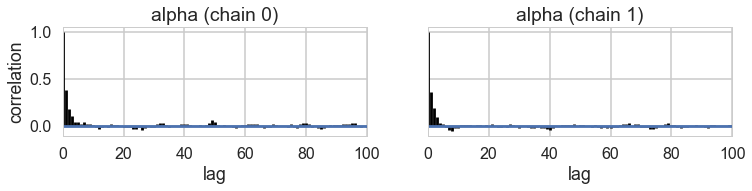

In [10]:
pm.autocorrplot(trace_ionly)

In [11]:
pm.summary(trace_ionly)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.321775,0.090689,0.001481,0.153754,0.507437,4036.972647,1.001251


In [12]:
full = full_model()
with full:
    trace_full=pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, betap, betapc]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:15<00:00, 762.98draws/s]


In [14]:
pm.summary(trace_full)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
betapc,-0.110130,0.266983,0.003550,-0.618182,0.419365,5873.657173,0.999921
betap,0.616664,0.225068,0.003449,0.183079,1.056363,5296.219309,1.000011
alpha,0.049458,0.124694,0.001553,-0.197278,0.289157,5492.921371,1.000234


array([<matplotlib.axes._subplots.AxesSubplot object at 0x11ac1f5c0>,
      dtype=object)

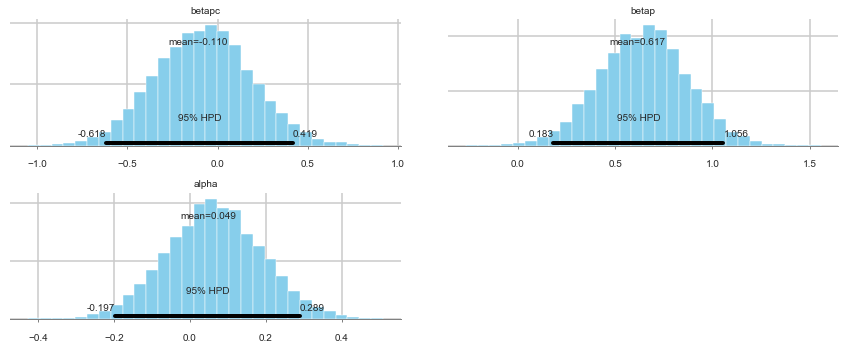

In [15]:
pm.plot_posterior(trace_full)

In [13]:
plonly = plonly_model()
with plonly:
    trace_plonly=pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, betap]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:10<00:00, 1112.99draws/s]


In [168]:
pm.summary(trace_plonly)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
betap,0.557852,0.185852,0.002627,0.190106,0.912260,3869.0,1.000059
alpha,0.048212,0.127505,0.001982,-0.202406,0.293146,3624.0,0.999904


>The estimated interaction effect bpC is negative, with a rather wide posterior on both sides of zero. So regardless of the information theory ranking, the estimates suggest that the chimpanzees did not care much about the other animal's presence. But they do prefer to pull the prosocial option, as indicated by the estimate for bp. (McElreath 296)

>First, let's consider the relative effect size of prosoc_left and its parameter bp. The customary measure of relative effect for a logistic model is the PROPORTIONAL CHANGE IN ODDS. You can compute the proportional odds by merely exponentiating the parameter estimate. Remember, odds are the ratio of the probability an event happens to the probability it does not happen. So in this case the relevant odds are the odds of pulling the left-hand lever (the outcome variable). If changing the predictor prosoc_left from 0 to 1 increases the log-odds of pulling the left-hand lever by 0.61 (the MAP estimate above), then this also implies that the odds are multiplied by: (McElreath 296)



In [16]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

In [17]:
np.exp(0.61)

1.8404313987816374

This is a 84% change in the log odds

In [169]:
invlogit(0.04), invlogit(0.04+0.61), invlogit(0.04+0.61-0.1)

(0.50999866687996553, 0.65701046267349883, 0.63413559101080075)

## Posteriors and Posterior predictives

First we create a trace function that takes into account the fact that we are using "nested" models, and that the full trace for $$logit(p)$$ can be obtained by setting some coefficients to 0

In [18]:
def trace_or_zero(trace, name):
    if name in trace.varnames:
        return trace[name]
    else:
        return np.zeros(2*len(trace))

Next we write a function for this trace

In [19]:
def model_pp(gridx, tracedict):
    temp = tracedict['alpha'] + gridx['P']*(tracedict['betap'] + tracedict['betapc']*gridx['C'])
    return temp

Now to compute the predictive, we get the trace of the logit, inverse logit it, and pass it through the sampling distribution.

In [20]:
def compute_pp(lpgrid, trace, tsize, paramnames, sampdistrib, invlink, inner_pp):
    tdict={}
    for pn in paramnames:
        tdict[pn] = trace_or_zero(trace, pn)
    print(tdict.keys(), tsize)
    tl=tsize
    gl=len(lpgrid)
    pp = np.empty((gl, tl))
    for i, v in enumerate(lpgrid):
        temp = inner_pp(lpgrid[i], tdict)
        pp[i,:] = sampdistrib(invlink(temp))
    return pp

We construct the grid we want the posterior predictive on:

In [21]:
import itertools
psleft = [0,1]
condition = [0,1]
xgrid = [{'C':v[0], 'P':v[1]} for v in itertools.product(condition, psleft)]

In [22]:
xgrid

[{'C': 0, 'P': 0}, {'C': 0, 'P': 1}, {'C': 1, 'P': 0}, {'C': 1, 'P': 1}]

### The average chimp posterior predictive

And then get the posterior predictive. But which one? Notice that in modelling this problem as a logistic regression, we are modeling each row of the data. 

But in the binomial below, we are modelling the story of the average of 7 chimps. We could do 10, 100, and so on and so off. 

Which should you use? Depends on the question you are asking

In [23]:
from scipy.stats import bernoulli, binom

In [24]:
ppdivisor=7
def like_sample(p_array):
    ppdivisor=7
    return binom.rvs(ppdivisor, p=p_array)

In [25]:
ppfull = compute_pp(xgrid, trace_full, 2*len(trace_full), trace_full.varnames, like_sample, invlogit, model_pp)

dict_keys(['betapc', 'betap', 'alpha']) 10000


In [26]:
ppfull

array([[5., 3., 3., ..., 5., 3., 5.],
       [2., 6., 6., ..., 3., 5., 3.],
       [5., 4., 1., ..., 3., 1., 5.],
       [5., 6., 4., ..., 5., 5., 6.]])

In [50]:
ppfull.shape

(4, 10000)

In [27]:
meanpp, stdpp = ppfull.mean(axis=1), ppfull.std(axis=1)

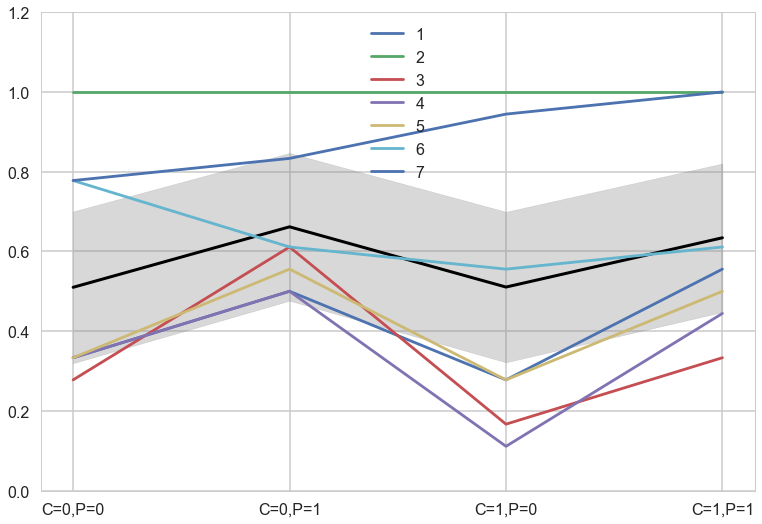

In [28]:
with sns.plotting_context('poster'):
    fmt = lambda d: ",".join([e+"="+str(d[e]) for e in d])
    plt.plot(range(4),meanpp/ppdivisor, lw=3, color="black")
    for i, chimp in enumerate(gd):
        plt.plot(range(4), gd[chimp], label=str(chimp))
    plt.fill_between(range(4), (meanpp-stdpp)/ppdivisor, (meanpp+stdpp)/ppdivisor, alpha=0.3, color="gray")
    plt.ylim([0,1.2])
    plt.xticks(range(4),[fmt(e) for e in xgrid])
    plt.legend();

### Per-Trial predictive

And this second likelihood gives us what happens for any one row, or any one experiment, independent of the chimp in question. So this predictive is asking the question, whats a new $y^{\ast}$ if u were to do this experiment again, with any of the chimps we have, on any block...

In [29]:
def ls2(p_array):
    return bernoulli.rvs(p=p_array)

In [30]:
ppfull2 = compute_pp(xgrid, trace_full, 2*len(trace_full), trace_full.varnames, ls2, invlogit, model_pp)
meanpp2, stdpp2 = ppfull2.mean(axis=1), ppfull2.std(axis=1)

dict_keys(['betapc', 'betap', 'alpha']) 10000


In [31]:
ppfull2

array([[1., 1., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 1., 1.],
       [0., 1., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 1.]])

In [32]:
ppfull2.mean(axis=1)

array([0.5076, 0.6644, 0.5142, 0.6223])

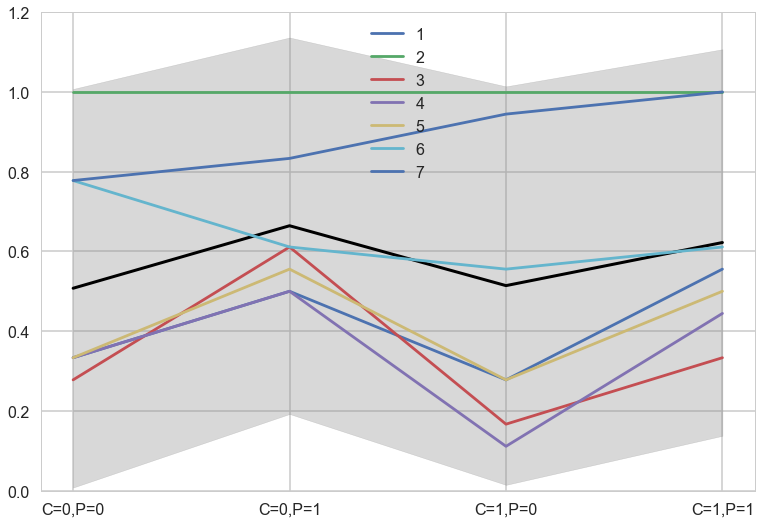

In [33]:
with sns.plotting_context('poster'):
    fmt = lambda d: ",".join([e+"="+str(d[e]) for e in d])
    plt.plot(range(4),meanpp2, lw=3, color="black")
    for i, chimp in enumerate(gd):
        plt.plot(range(4), gd[chimp], label=str(chimp))
    plt.fill_between(range(4), (meanpp2-stdpp2), (meanpp2+stdpp2), alpha=0.3, color="gray")
    plt.ylim([0,1.2])
    plt.xticks(range(4),[fmt(e) for e in xgrid])
    plt.legend();

>The colored lines display the empirical averages for each of the seven chimpanzees who participated in the experiment. The black line shows the average predicted probability of pulling the left-hand lever, across treatments. The zig-zag pattern arises from more left-hand pulls when the prosocial option is on the left. So the chimpanzees were, at least on average, attracted to the prosocial option. But the partner condition, shown by the last two treatment on the far right of the figure, are no higher than the first two treatments from the control condition. So it made little difference whether or not another animal was present to receive the food on the other side of the table. (McElreath 297-298)


## Modeling as a binomial

>In the chimpanzees data context, the models all calculated the likelihood of observing either zero or one pulls of the left-hand lever. The models did so, because the data were organized such that each row describes the outcome of a single pull. But in principle the same data could be organized differently. As long as we don't care about the order of the individual pulls, the same information is contained in a count of how many times each individual pulled the left-hand lever, for each combination of predictor variables. (McElreath 303)



## A heirarchical model for a per-chimp question

>Now back to modeling individual variation. There is plenty of evidence of handedness in these data. Four of the individuals tend to pull the right-hand lever, across all treatments. Three individuals tend to pull the left across all treatments. One individual, actor number 2, always pulled the left-hand lever, regardless of treatment. That's the horizontal green line at the top (McElreath 299)

>Think of handedness here as a masking variable. If we can model it well, maybe we can get a better picture of what happened across treatments. So what we wish to do is estimate handedness as a distinct intercept for each individual, each actor. You could do this using a dummy variable for each individual. But it'll be more convenient to use a vector of intercepts, one for each actor. This form is equivalent to making dummy variables, but it is more compact  (McElreath 299)


Here we have a varying intercepts model

![](images/multichimp.png)

In [34]:
def vi_model():
    with pm.Model() as vi:
        betapc = pm.Normal("betapc", 0, 10)
        betap = pm.Normal("betap", 0, 10)
        alpha = pm.Normal('alpha', 0, 10)
        sigma_actor = pm.HalfCauchy("sigma_actor", 1)
        alpha_actor = pm.Normal('alpha_actor', 0, sigma_actor, shape=7)
        logitpi = alpha + alpha_actor[df.index//72] + (betap + betapc*df.condition)*df.prosoc_left
        o = pm.Bernoulli("pulled_left", p=pm.math.invlogit(logitpi), observed=df.pulled_left)
        
    return vi

In [35]:
vi = vi_model()
with vi:
    step=pm.NUTS(target_accept=0.95)
    vi_trace=pm.sample(10000, tune=4000, step=step)

//anaconda/envs/py3l/lib/python3.6/site-packages/theano/tensor/subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
//anaconda/envs/py3l/lib/python3.6/site-packages/theano/tensor/subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha_actor, sigma_actor, alpha, betap, betapc]
Sampling 2 chains: 100%|██████████| 28000/28000 [04:39<00:00, 100.17draws/s]
The number of effective samples

//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


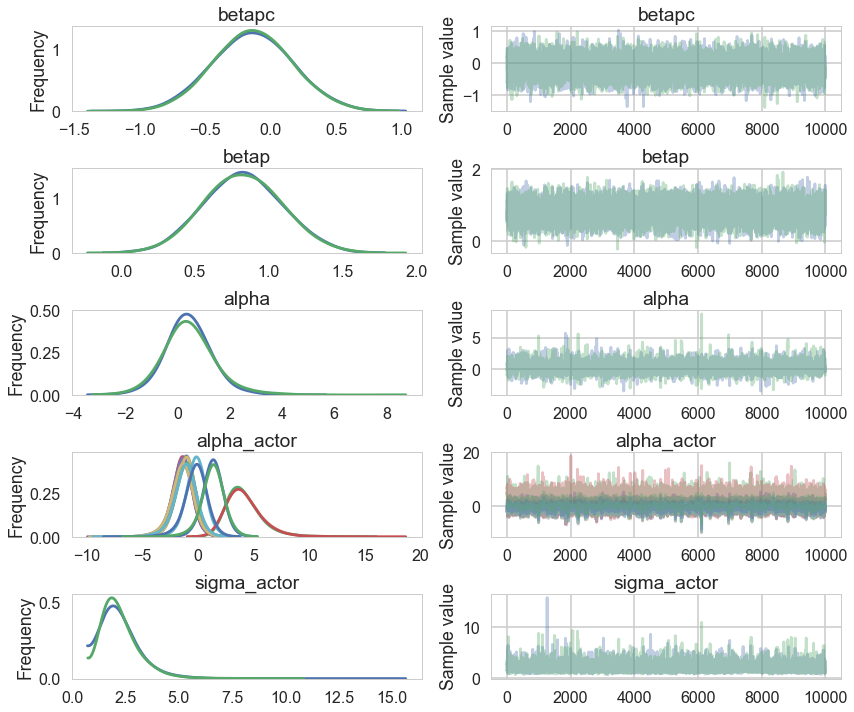

In [36]:
pm.traceplot(vi_trace);

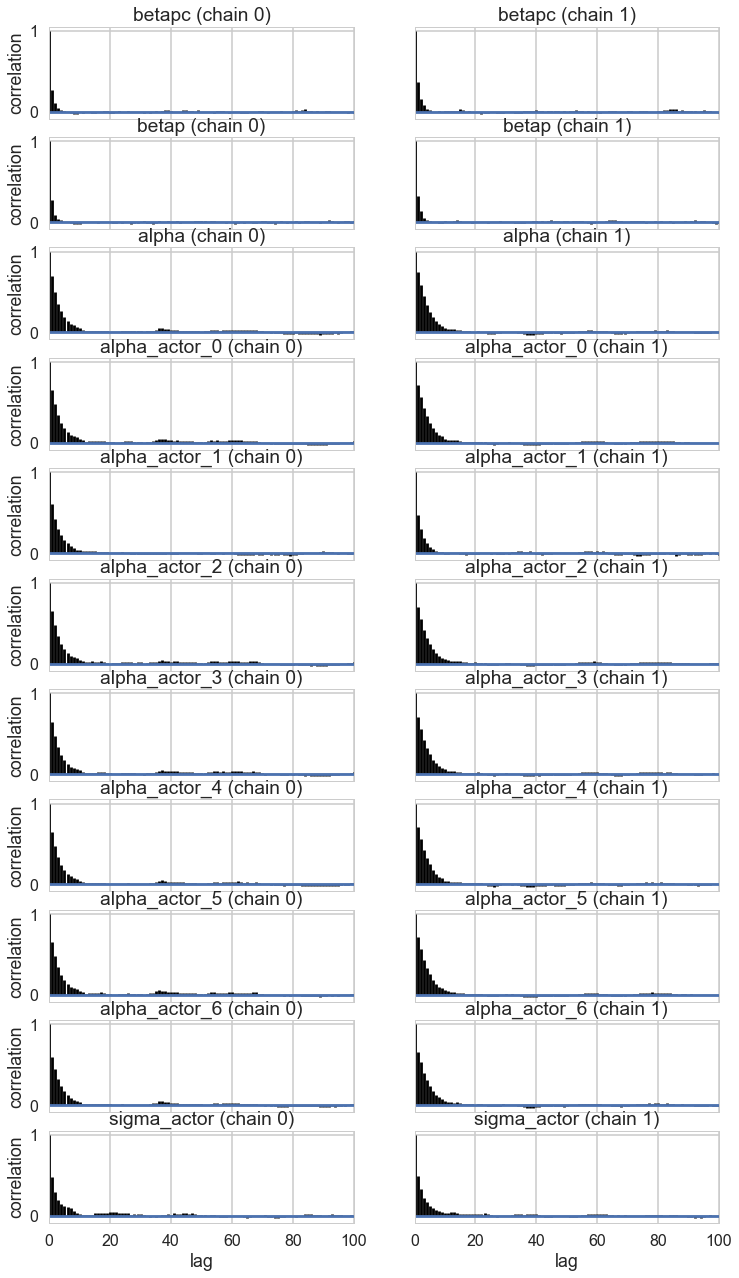

In [37]:
pm.autocorrplot(vi_trace);

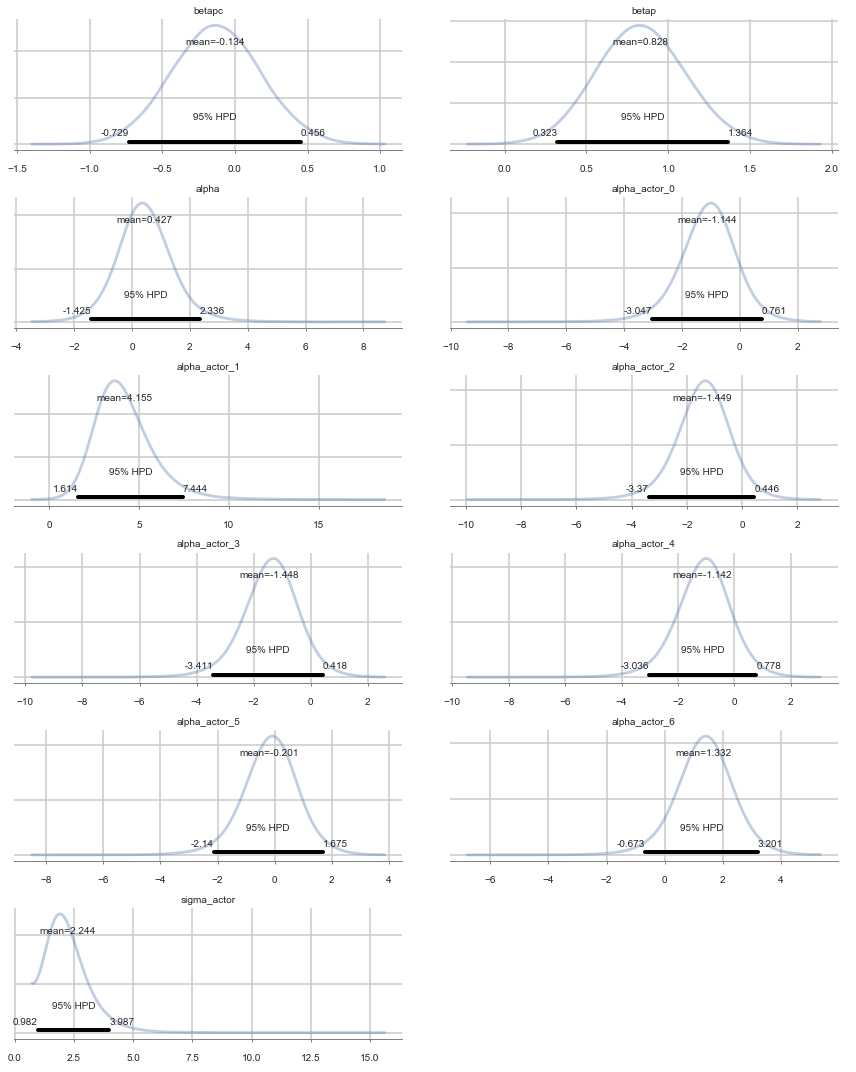

In [38]:
pm.plot_posterior(vi_trace, kde_plot=True);

Positive values of `alpha_actor` indicate a preference for the left side.

>You can see that there is strong skew here. Plausible values of `alpha_actor__1` are always positive, indicating a left-hand bias. But the range of plausible values is truly enormous. What has happened here is that many very large positive values are plausible, because actor number 2 always pulled the left-hand lever (McElreath 300)



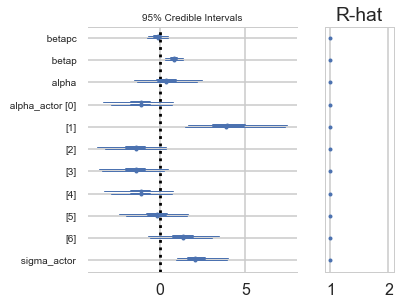

In [39]:
pm.forestplot(vi_trace);

In [40]:
pm.summary(vi_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
betapc,-0.133790,0.301752,0.002978,-0.728758,0.455756,9610.191093,0.999983
betap,0.827516,0.266267,0.002530,0.323074,1.363851,10186.920359,0.999950
alpha,0.426953,0.928396,0.019119,-1.424520,2.336255,2865.314221,1.000316
alpha_actor__0,-1.143878,0.947489,0.019040,-3.047342,0.761483,2988.572452,1.000373
alpha_actor__1,4.155300,1.566357,0.023300,1.614331,7.444291,4432.622946,0.999975
alpha_actor__2,-1.448670,0.948786,0.019059,-3.370019,0.445741,3006.488563,1.000282
alpha_actor__3,-1.448100,0.947868,0.018868,-3.410750,0.418253,3022.314049,1.000306
alpha_actor__4,-1.141801,0.949983,0.018817,-3.035654,0.778060,3013.043930,1.000374
alpha_actor__5,-0.201116,0.946678,0.019071,-2.140443,1.675186,2984.123406,1.000250
alpha_actor__6,1.332294,0.967247,0.018574,-0.673068,3.201170,3164.252808,1.000274


In [41]:
vi_trace['alpha_actor'][:,1].shape

(20000,)

### Predictives are on individuals now

>You can best appreciate the way these individual intercepts influence fit by plotting posterior predictions again. The code below just modifies the code from earlier to show only a single individual, the one specified by the first line.  (McElreath 301)



In [42]:
def like_sample_hier(p_array):
    return bernoulli.rvs(p=p_array)

In [43]:
def model_pp_hier(gridx, tracedict, ix):
    temp = tracedict['alpha'] + tracedict['alpha_actor'][:,ix]+gridx['P']*(tracedict['betap'] + tracedict['betapc']*gridx['C'])
    return temp

In [44]:
def compute_pp2(lpgrid, trace, paramnames, sampdistrib, invlink, inner_pp, ix):
    tdict=trace
    tl=2*len(trace)
    gl=len(lpgrid)
    pp = np.empty((gl, tl))
    for i, v in enumerate(lpgrid):
        temp = inner_pp(lpgrid[i], tdict, ix)
        pp[i,:] = invlink(temp)
    return pp

In [45]:
vi_trace.varnames

['betapc', 'betap', 'alpha', 'sigma_actor_log__', 'alpha_actor', 'sigma_actor']

In [46]:
vnames=['betapc', 'betap', 'alpha', 'alpha_actor']
pphier0=compute_pp2(xgrid, vi_trace, vnames, like_sample_hier, invlogit, model_pp_hier, 0)

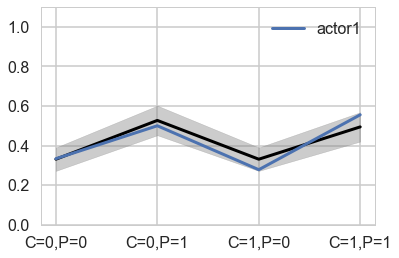

In [47]:
ppdivisor=1
meanpp, stdpp = pphier0.mean(axis=1), pphier0.std(axis=1)
fmt = lambda d: ",".join([e+"="+str(d[e]) for e in d])
plt.plot(range(4),meanpp/ppdivisor, lw=3, color="black")
plt.plot(range(4), gd[1], label="actor{}".format(1), lw=3)
plt.fill_between(range(4), (meanpp-stdpp)/ppdivisor, (meanpp+stdpp)/ppdivisor, alpha=0.4, color="gray")
plt.ylim([0,1.1])
plt.xticks(range(4),[fmt(e) for e in xgrid])
plt.legend();

In [48]:
pphier6=compute_pp2(xgrid, vi_trace, vnames, like_sample_hier, invlogit, model_pp_hier, 6)

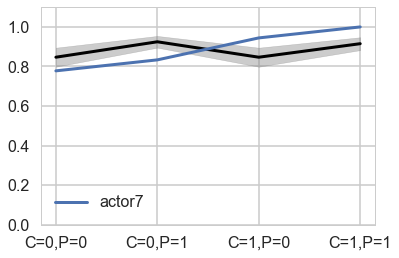

In [49]:
ppdivisor=1
meanpp, stdpp = pphier6.mean(axis=1), pphier6.std(axis=1)
fmt = lambda d: ",".join([e+"="+str(d[e]) for e in d])
plt.plot(range(4),meanpp/ppdivisor, lw=3, color="black")
plt.plot(range(4), gd[7], label="actor{}".format(7), lw=3)
plt.fill_between(range(4), (meanpp-stdpp)/ppdivisor, (meanpp+stdpp)/ppdivisor, alpha=0.4, color="gray")
plt.ylim([0,1.1])
plt.xticks(range(4),[fmt(e) for e in xgrid])
plt.legend();

>Notice that these individual intercepts do help the model fit the overall level for each chimpanzee. But they do not change the basic zig-zag prediction pattern across treatments. (McElreath 302)